In [13]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from commpy.utilities  import signal_power, upsample
from commpy.modulation import Modem, QAMModem
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR, edc, fourthPowerFOE, dbp, cpr
from utils.models import mzm, linFiberCh, iqm, ssfm, edfa, phaseNoise, coherentReceiver

from scipy import signal
import scipy.constants as const

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

# Simulation of coherent WDM systems

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coherent-WDM-system" data-toc-modified-id="Coherent-WDM-system-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Coherent WDM system</a></span><ul class="toc-item"><li><span><a href="#Transmitter" data-toc-modified-id="Transmitter-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Transmitter</a></span></li></ul></li></ul></div>

## Coherent WDM system

### Transmitter

In [4]:
def simpleWDMTx(param):
    
    # transmitter parameters
    Ts  = 1/param.Rs        # symbol period [s]
    Fa  = 1/(Ts/param.SpS)  # sampling frequency [samples/s]
    Ta  = 1/Fa              # sampling period [s]
    
    # central frequencies of the WDM channels
    freqGrid = np.arange(-np.floor(param.Nch/2), np.floor(param.Nch/2)+1,1)*param.freqSpac
    
    if (param.Nch % 2) == 0:
        freqGrid += param.freqSpac/2
        
    # IQM parameters
    Ai = 1
    Vπ = 2
    Vb = -Vπ
    Pch = 10**(param.Pch_dBm/10)*1e-3   # optical signal power per WDM channel
        
    π = np.pi
    
    t = np.arange(0, int(((param.Nbits)/np.log2(param.M))*param.SpS))
    
    # allocate array 
    sigTxWDM  = np.zeros((len(t), param.Nmodes), dtype='complex')
    symbTxWDM = np.zeros((int(len(t)/param.SpS), param.Nmodes, param.Nch), dtype='complex')
    
    Psig = 0
    
    for indMode in range(0, param.Nmodes):        
        print('Mode #%d'%(indMode))
        
        for indCh in range(0, param.Nch):
            # generate random bits
            bitsTx   = np.random.randint(2, size=param.Nbits)    

            # map bits to constellation symbols
            mod = QAMModem(m=param.M)
            symbTx = mod.modulate(bitsTx)
            Es = mod.Es

            # normalize symbols energy to 1
            symbTx = symbTx/np.sqrt(Es)
            
            symbTxWDM[:,indMode,indCh] = symbTx
            
            # upsampling
            symbolsUp = upsample(symbTx, param.SpS)

            # pulse shaping
            if param.pulse == 'nrz':
                pulse = pulseShape('nrz', param.SpS)
            elif param.pulse == 'rrc':
                pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=Ts)

            pulse = pulse/np.max(np.abs(pulse))

            # formatação de pulso
            sigTx  = firFilter(pulse, symbolsUp)

            # optical modulation
            sigTxCh = iqm(Ai, 0.5*sigTx, Vπ, Vb, Vb)
            sigTxCh = np.sqrt(Pch/param.Nmodes)*sigTxCh/np.sqrt(signal_power(sigTxCh))
            
            print('channel %d power : %.2f dBm, fc : %3.4f THz' 
                  %(indCh+1, 10*np.log10(signal_power(sigTxCh)/1e-3), 
                    (param.Fc+freqGrid[indCh])/1e12))

            sigTxWDM[:,indMode] = sigTxWDM[:,indMode] + sigTxCh*np.exp(1j*2*π*(freqGrid[indCh]/Fa)*t)
            
        Psig = Psig + signal_power(sigTxWDM[:,indMode])
        
    print('total WDM signal power: %.2f dBm'%(10*np.log10(Psig/1e-3)))
    
    return sigTxWDM, symbTxWDM, freqGrid

In [5]:
class parameters:
    pass

In [6]:
help(ssfm)

Help on function ssfm in module utils.models:

ssfm(Ei, Fs, Ltotal, Lspan, hz=0.5, alpha=0.2, gamma=1.3, D=16, Fc=193100000000000.0, amp='edfa', NF=4.5)
    Split-step Fourier method (symmetric, single-pol.)
    
    :param Ei: input signal
    :param Ltotal: total fiber length [km]
    :param Lspan: span length [km]
    :param hz: step-size for the split-step Fourier method [km][default: 0.5 km]
    :param alpha: fiber attenuation parameter [dB/km][default: 0.2 dB/km]
    :param D: chromatic dispersion parameter [ps/nm/km][default: 16 ps/nm/km]
    :param gamma: fiber nonlinear parameter [1/W/km][default: 1.3 1/W/km]
    :param amp: 'edfa', 'ideal', or 'None. [default:'edfa']
    :param NF: edfa noise figure [dB] [default: 4.5 dB]
    :param Fc: carrier frequency [Hz] [default: 193.1e12 Hz]
    :param Fs: sampling frequency [Hz]
    
    :return Ech: propagated signal



**WDM signal generation**

In [7]:
# Parâmetros do transmissor:
param = parameters()
param.M   = 64            # ordem do formato de modulação
param.Rs  = 32e9         # taxa de sinalização [baud]
param.SpS = 16           # número de amostras por símbolo
param.Nbits = 60000      # número de bits
param.pulse = 'rrc'      # formato de pulso
param.Ntaps = 4096       # número de coeficientes do filtro RRC
param.alphaRRC = 0.01    # rolloff do filtro RRC
param.Pch_dBm = -1       # potência média por canal WDM [dBm]
param.Nch     = 9        # número de canais WDM
param.Fc      = 193.1e12 # frequência central do espectro WDM
param.freqSpac = 40e9    # espaçamento em frequência da grade de canais WDM
param.Nmodes = 1         # número de modos de polarização

sigWDM_Tx, symbTx_, freqGrid = simpleWDMTx(param)

Mode #0
channel 1 power : -1.00 dBm, fc : 192.9400 THz
channel 2 power : -1.00 dBm, fc : 192.9800 THz
channel 3 power : -1.00 dBm, fc : 193.0200 THz
channel 4 power : -1.00 dBm, fc : 193.0600 THz
channel 5 power : -1.00 dBm, fc : 193.1000 THz
channel 6 power : -1.00 dBm, fc : 193.1400 THz
channel 7 power : -1.00 dBm, fc : 193.1800 THz
channel 8 power : -1.00 dBm, fc : 193.2200 THz
channel 9 power : -1.00 dBm, fc : 193.2600 THz
total WDM signal power: 8.54 dBm


**Nonlinear fiber propagation with the split-step Fourier method**

In [8]:
canalLinear = True

# optical channel parameters
Ltotal = 400   # km
Lspan  = 80    # km
alpha = 0.2    # dB/km
D = 16         # ps/nm/km
Fc = 193.1e12  # Hz
hz = 0.5       # km
gamma = 1.3    # 1/(W.km)

if canalLinear:
    hz = Lspan  # km
    gamma = 0   # 1/(W.km)
    
sigWDM = ssfm(sigWDM_Tx, param.Rs*param.SpS, Ltotal, Lspan, hz, alpha, gamma, D, Fc, amp='ideal') 

**Optical WDM spectrum before and after transmission**

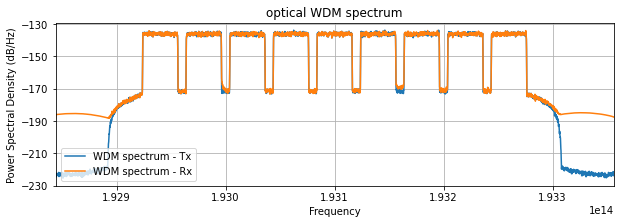

In [9]:
# plot psd
plt.figure()
plt.xlim(Fc-param.SpS*param.Rs/2,Fc+param.SpS*param.Rs/2);
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, Fc=Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM, Fs=param.SpS*param.Rs, Fc=Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

**WDM channels coherent detection and demodulation**

Demodulando canal #4 , fc: 193.1000 THz, λ: 1552.5244 nm
Oscilador local P: 10.00 dBm, lw: 0.00 kHz, FO: 0.00 MHz
FO estimado: 0.0000 MHz
SNR[est] = 36.11 dB 

Total de bits = 58000  
Total de erros contados = 0  
BER = 0.00e+00  


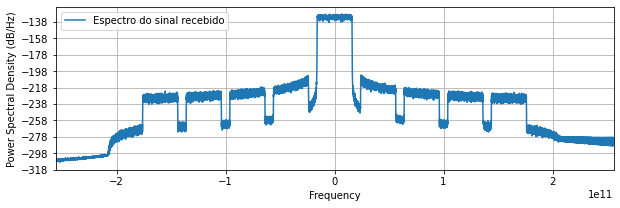

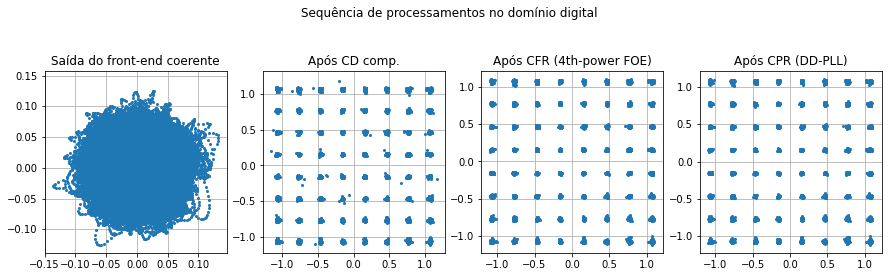

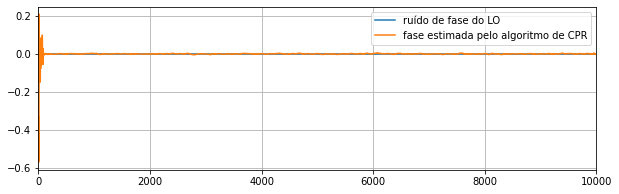

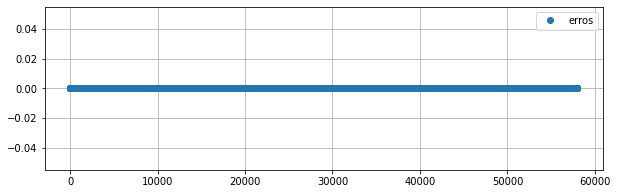

In [14]:
### Receptor

# parâmetros
chIndex = 4 # índice do canal a ser demodulado
plotPSD = True

Fa = param.SpS*param.Rs
Ta = 1/Fa
mod = QAMModem(m=param.M)

print('Demodulando canal #%d , fc: %.4f THz, λ: %.4f nm'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

sigWDM = sigWDM.reshape(len(sigWDM),)
symbTx = symbTx_[:,:,chIndex].reshape(len(symbTx_),)

# parâmetros do oscilador local:
FO      = 0*128e6                 # desvio de frequência
Δf_lo   = freqGrid[chIndex]+FO  # downshift canal a ser demodulado
lw      = 0*100e3                 # largura de linha
Plo_dBm = 10                    # potência em dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # potência em W
ϕ_lo    = 0                     # fase inicial em rad     

print('Oscilador local P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# gera sinal do oscilador local
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ta
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ta)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# receptor óptico coerente
sigRx = coherentReceiver(sigWDM, sigLO)

# filtragem Rx

# filtro casado
if param.pulse == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=1/param.Rs)

pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plota psd
if plotPSD:
    plt.figure();
   # plt.ylim(-250,-50);
    plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal recebido')
    plt.legend(loc='upper left');
    plt.xlim(-Fa/2,Fa/2);

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(15,4.5))
fig.suptitle('Sequência de processamentos no domínio digital')

ax1.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax1.axis('square')
ax1.title.set_text('Saída do front-end coerente')
ax1.grid()

# digital backpropagation
# hzDBP = 5
# Pin   = 10**(param.Pch_dBm/10)*1e-3
# sigRx = sigRx/np.sqrt(signal_power(sigRx))
# sigRx = dbp(np.sqrt(Pin)*sigRx, Fa, Ltotal, Lspan, hzDBP, alpha, gamma, D, Fc)
# sigRx = sigRx.reshape(len(sigRx),)
# sigRx = firFilter(pulse, sigRx)
    
# compensação dispersão cromática
sigRx = edc(sigRx, Ltotal, D, Fc-Δf_lo, Fa)

# captura amostras no meio dos intervalos de sinalização
varVector = np.var((sigRx.T).reshape(-1,param.SpS), axis=0) # acha o melhor instante de amostragem
sampDelay = np.where(varVector == np.amax(varVector))[0][0]

# downsampling
sigRx = sigRx[sampDelay::param.SpS]

discard = 1000
ind = np.arange(discard, sigRx.size-discard)

# normaliza símbolos recebidos
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# plota constelação após compensação da dispersão cromática
ax2.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax2.axis('square')
ax2.title.set_text('Após CD comp.')
ax2.grid()

# calcula atraso gerado pelo walkoff
symbDelay = np.argmax(signal.correlate(np.abs(symbTx), np.abs(sigRx)))-sigRx.size+1 

# compensa atraso do walkoff
sigRx = np.roll(sigRx, symbDelay)

# normaliza constelação recebida
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# estima e compensa desvio de frequência entre sinal e LO
fo = fourthPowerFOE(sigRx, 1/param.Rs)
print('FO estimado: %3.4f MHz'%(fo/1e6))

sigRx = sigRx*np.exp(-1j*2*π*fo*np.arange(0,len(sigRx))/param.Rs)

# plota constelação após compensação do desvio de frequência entre sinal e LO
ax3.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax3.axis('square')
ax3.title.set_text('Após CFR (4th-power FOE)')
ax3.grid()

# compensa ruído de fase
windowSize = 80
c  = mod.constellation/np.sqrt(mod.Es)
sigRx, ϕ, θ = cpr(sigRx, windowSize, c, symbTx)

# plota saídas do estimador de fase
phaseOffSet = np.mean(np.roll(ϕ_pn_lo[::param.SpS], symbDelay)-θ)
plt.figure()
plt.plot(np.roll(ϕ_pn_lo[::param.SpS], symbDelay), label='ruído de fase do LO');
plt.plot(θ+phaseOffSet, label='fase estimada pelo algoritmo de CPR');
plt.grid()
plt.xlim(0,θ.size)
plt.legend();

# corrige (possível) ambiguidade de fase adicionada ao sinal
rot = np.mean(symbTx[ind]/sigRx[ind])
sigRx  = rot*sigRx

# normaliza símbolos recebidos
sigRx = sigRx/np.sqrt(signal_power(sigRx[ind]))

# plota constelação após compensação do ruído de fase
ax4.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax4.axis('square')
ax4.title.set_text('Após CPR (DD-PLL)')
ax4.grid()

# estima SNR da constelação recebida
SNR = signal_power(symbTx[ind])/signal_power(sigRx[ind]-symbTx[ind])

# Demodulação com aplicação a regra de decisão brusca        
bitsRx = mod.demodulate(np.sqrt(mod.Es)*sigRx, demod_type = 'hard') 
bitsTx = mod.demodulate(np.sqrt(mod.Es)*symbTx, demod_type = 'hard') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de bits = %d  '%(err.size))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

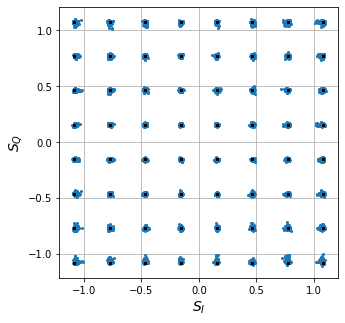

In [15]:
plt.figure(figsize=(5,5))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-1.1,1.1)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx');

In [ ]:
from scipy.stats.kde import gaussian_kde

y = (sigRx[ind]).real
x = (sigRx[ind]).imag

k = gaussian_kde(np.vstack([x, y]))
k.set_bandwidth(bw_method=k.factor/4)

xi, yi = 1.1*np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.figure(figsize=(5,5))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1, shading='auto');

In [ ]:
def powerProfile(Pin, alpha, Lspan, Nspans):
    
    L = np.linspace(0, Nspans*Lspan, 2000)
    
    power = Pin-alpha*(L%Lspan)
    
    plt.plot(L, power,'')
    plt.xlabel('L [km]')
    plt.ylabel('power [dBm]')
    plt.title('Power profile')
    plt.grid()
    plt.xlim(min(L), max(L))

In [ ]:
powerProfile(10, 0.2, 80, 10)